In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchxrayvision as xrv
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Ρυθμίσεις
CHEXPERT_PATH = "C:/Users/chtzo/Desktop/CheXpert-v1.0-small"  # Το path του dataset σου
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [42]:
# 1. Φόρτωση μοντέλου
print("Loading CheXpert DenseNet121 model...")
model = xrv.models.DenseNet(weights="densenet121-res224-chex")
model = model.to(DEVICE)
model.eval()

print(f"Model labels: {model.pathologies}")
print(f"Number of classes: {len(model.pathologies)}")

Loading CheXpert DenseNet121 model...
Model labels: ['Atelectasis', 'Consolidation', '', 'Pneumothorax', 'Edema', '', '', 'Effusion', 'Pneumonia', '', 'Cardiomegaly', '', '', '', 'Lung Lesion', 'Fracture', 'Lung Opacity', 'Enlarged Cardiomediastinum']
Number of classes: 18


In [43]:
# 2. Φόρτωση dataset metadata
train_csv = pd.read_csv(os.path.join(CHEXPERT_PATH, "train.csv"))
print(f"\nDataset shape: {train_csv.shape}")
print(f"Columns: {train_csv.columns.tolist()}")


Dataset shape: (223414, 19)
Columns: ['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


In [59]:
# 3. Επιλογή ενός sample image
# Παίρνουμε μια εικόνα που έχει frontal view
frontal_images = train_csv[train_csv['Frontal/Lateral'] == 'Frontal']
sample_idx = 500
sample_row = frontal_images.iloc[sample_idx]

# Το Path στο CSV είναι σχετικό και ξεκινάει με "CheXpert-v1.0-small/"
relative_path = sample_row['Path'].replace('CheXpert-v1.0-small/', '')
image_path = os.path.join(CHEXPERT_PATH, relative_path)

print(f"\nSample image: {image_path}")
print(f"Relative path in CSV: {sample_row['Path']}")
print(f"Patient info: {sample_row['Sex']}, Age: {sample_row['Age']}")

# Έλεγχος αν υπάρχει το αρχείο
if not os.path.exists(image_path):
    print(f"⚠️  WARNING: Image not found at {image_path}")
    print(f"Looking for alternative...")
    # Δοκιμάζουμε να βρούμε την πρώτη υπαρκτή εικόνα
    for idx in range(len(frontal_images)):
        test_row = frontal_images.iloc[idx]
        relative_path = test_row['Path'].replace('CheXpert-v1.0-small/', '')
        test_path = os.path.join(CHEXPERT_PATH, relative_path)
        if os.path.exists(test_path):
            image_path = test_path
            sample_row = test_row
            print(f"✓ Found image: {image_path}")
            break
else:
    print(f"✓ Image file exists")


Sample image: C:/Users/chtzo/Desktop/CheXpert-v1.0-small\train/patient00147/study13/view1_frontal.jpg
Relative path in CSV: CheXpert-v1.0-small/train/patient00147/study13/view1_frontal.jpg
Patient info: Male, Age: 53
✓ Image file exists


In [60]:
# 4. Προεπεξεργασία εικόνας
def load_and_preprocess_image(img_path):
    """Φορτώνει και προεπεξεργάζεται την εικόνα για το μοντέλο"""
    img = Image.open(img_path).convert('RGB')
    
    # Μετατροπή σε grayscale
    img_gray = np.array(img.convert('L'))
    
    # Resize to 224x224
    img_resized = Image.fromarray(img_gray).resize((224, 224), Image.BILINEAR)
    img_array = np.array(img_resized).astype(np.float32)
    
    # Normalize όπως το torchxrayvision
    img_normalized = img_array / 255.0
    img_normalized = (img_normalized - 0.5) * 2 * 1024  # [-1024, 1024]
    
    # Convert to tensor [1, 1, 224, 224]
    img_tensor = torch.from_numpy(img_normalized).unsqueeze(0).unsqueeze(0)
    
    # Για visualization (RGB normalized στο [0,1])
    img_rgb = np.stack([img_array/255.0]*3, axis=-1)
    
    return img_tensor, img_rgb, img_gray

img_tensor, img_rgb, original_img = load_and_preprocess_image(image_path)
img_tensor = img_tensor.to(DEVICE)

In [61]:
# 5. Prediction
print("\n" + "="*50)
print("PREDICTIONS")
print("="*50)

with torch.no_grad():
    outputs = model(img_tensor)
    predictions = torch.sigmoid(outputs).cpu().numpy()[0]

# Εμφάνιση predictions
for i, pathology in enumerate(model.pathologies):
    prob = predictions[i]
    print(f"{pathology:20s}: {prob:.3f} {'⚠️' if prob > 0.5 else ''}")


PREDICTIONS
Atelectasis         : 0.682 ⚠️
Consolidation       : 0.645 ⚠️
                    : 0.622 ⚠️
Pneumothorax        : 0.633 ⚠️
Edema               : 0.670 ⚠️
                    : 0.622 ⚠️
                    : 0.622 ⚠️
Effusion            : 0.658 ⚠️
Pneumonia           : 0.660 ⚠️
                    : 0.622 ⚠️
Cardiomegaly        : 0.625 ⚠️
                    : 0.622 ⚠️
                    : 0.622 ⚠️
                    : 0.622 ⚠️
Lung Lesion         : 0.676 ⚠️
Fracture            : 0.696 ⚠️
Lung Opacity        : 0.696 ⚠️
Enlarged Cardiomediastinum: 0.643 ⚠️


In [62]:
# 6. Grad-CAM με pytorch_grad_cam
print("\nGenerating Grad-CAM heatmaps...")

# Το target layer για DenseNet είναι το τελευταίο norm layer
target_layers = [model.features.norm5]

# Wrapper class για να δουλέψει με pytorch-grad-cam
class ModelWrapper(torch.nn.Module):
    def __init__(self, model, class_idx):
        super().__init__()
        self.model = model
        self.class_idx = class_idx
    
    def forward(self, x):
        output = self.model(x)
        # Επιστρέφουμε μόνο την κλάση που μας ενδιαφέρει
        return output[:, self.class_idx:self.class_idx+1]

# Δημιουργία heatmaps για όλες τις κλάσεις
heatmaps = []
for class_idx in range(len(model.pathologies)):
    # Wrap το μοντέλο για κάθε κλάση
    wrapped_model = ModelWrapper(model, class_idx)
    wrapped_model.eval()
    
    # Δημιουργία GradCAM
    cam = GradCAM(model=wrapped_model, target_layers=target_layers)
    
    # Υπολογισμός heatmap
    grayscale_cam = cam(input_tensor=img_tensor, targets=None)
    heatmaps.append(grayscale_cam[0])

print(f"✓ Generated {len(heatmaps)} heatmaps")


Generating Grad-CAM heatmaps...
✓ Generated 18 heatmaps



✓ Heatmaps saved as 'chexpert_heatmaps.png'


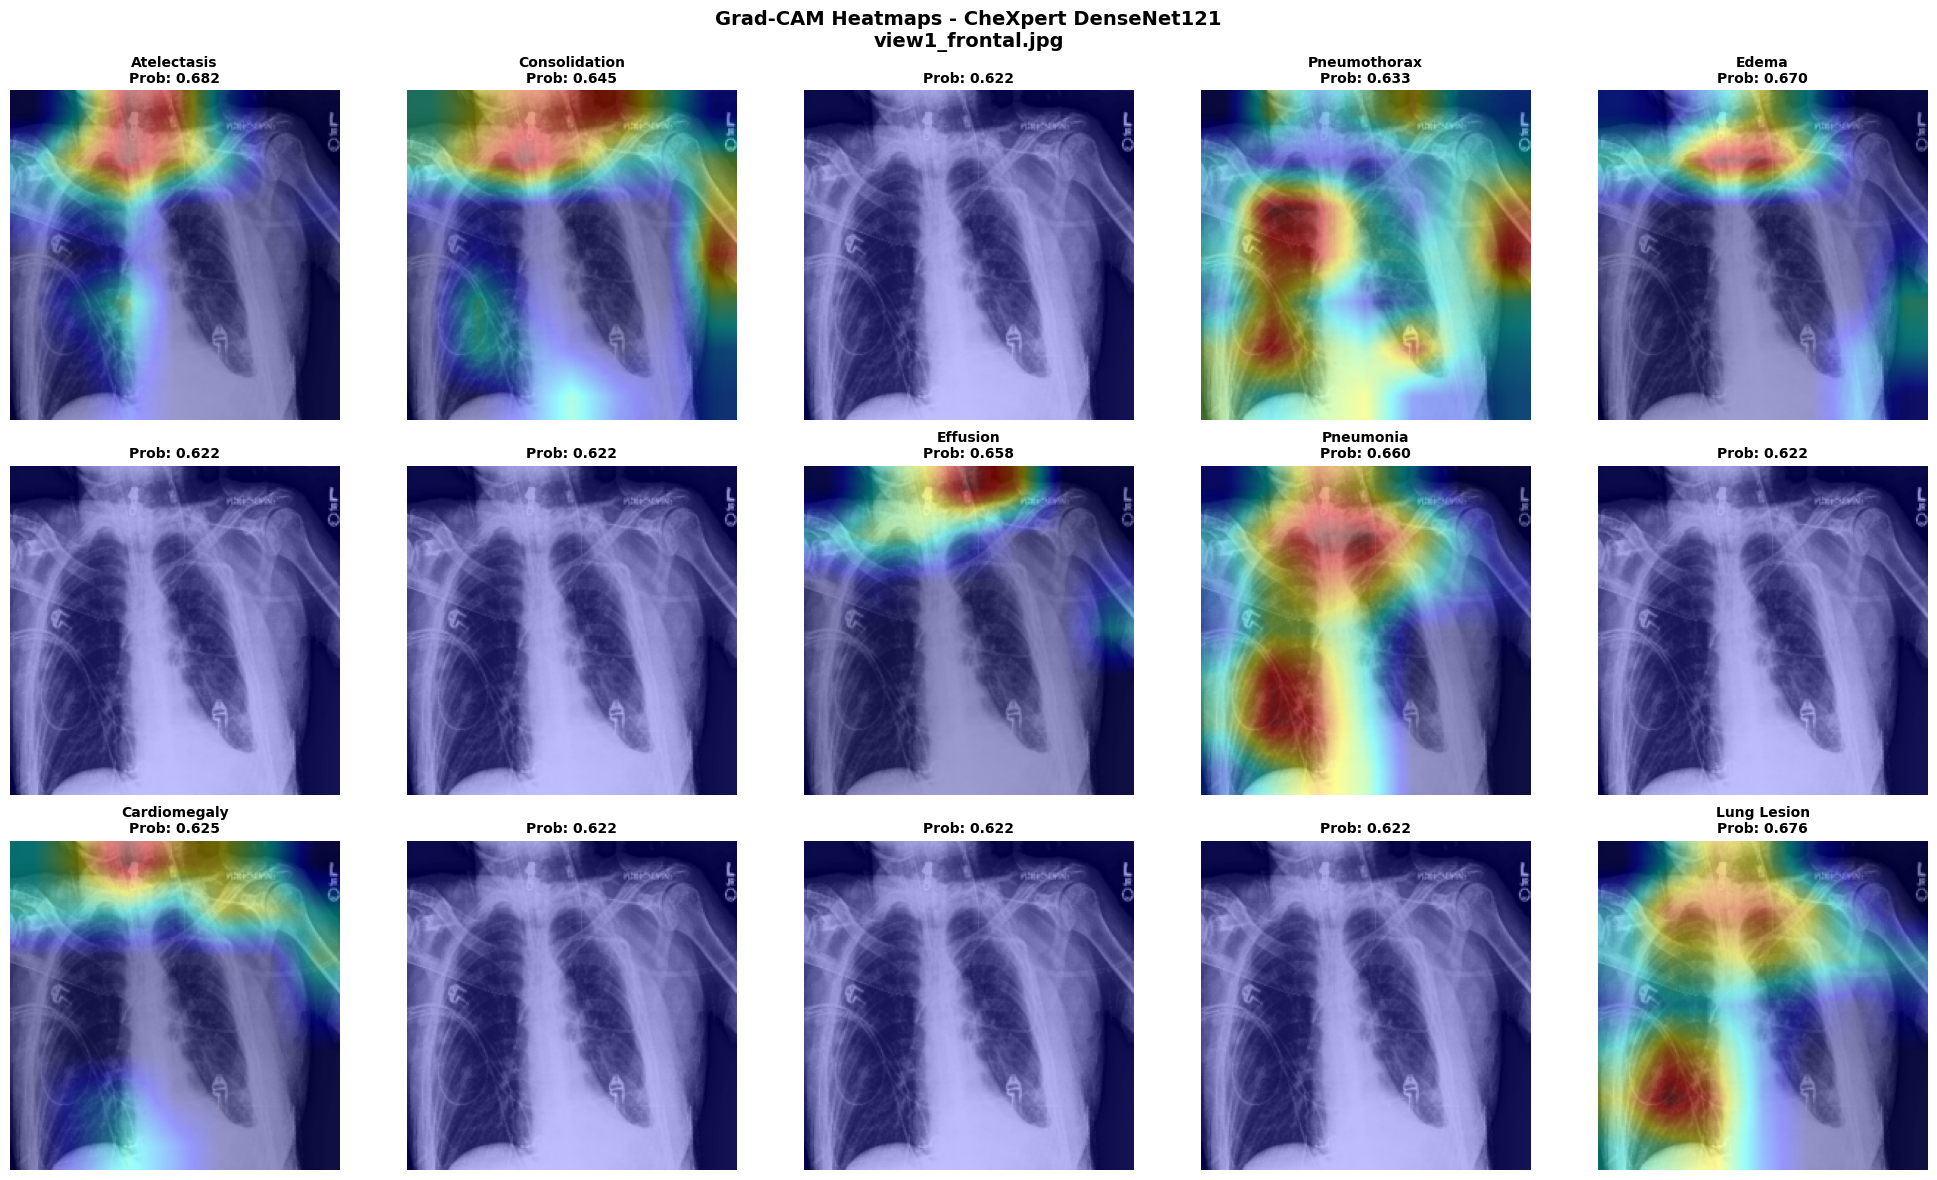

In [63]:
# 7. Visualization - Όλα τα heatmaps
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for i, (pathology, heatmap, prob) in enumerate(zip(model.pathologies, heatmaps, predictions)):
    if i < len(axes):
        ax = axes[i]
        
        # Overlay heatmap στην εικόνα
        visualization = show_cam_on_image(img_rgb, heatmap, use_rgb=True, image_weight=0.6)
        
        ax.imshow(visualization)
        ax.set_title(f"{pathology}\nProb: {prob:.3f}", fontsize=10, fontweight='bold')
        ax.axis('off')

# Hide unused subplots
for i in range(len(model.pathologies), len(axes)):
    axes[i].axis('off')

plt.suptitle(f"Grad-CAM Heatmaps - CheXpert DenseNet121\n{os.path.basename(image_path)}", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('chexpert_heatmaps.png', dpi=150, bbox_inches='tight')
print("\n✓ Heatmaps saved as 'chexpert_heatmaps.png'")
plt.show()


TOP 5 PREDICTIONS
1. Fracture            : 0.696
2. Lung Opacity        : 0.696
3. Atelectasis         : 0.682
4. Lung Lesion         : 0.676
5. Edema               : 0.670

✓ Top 5 predictions saved as 'chexpert_top5.png'


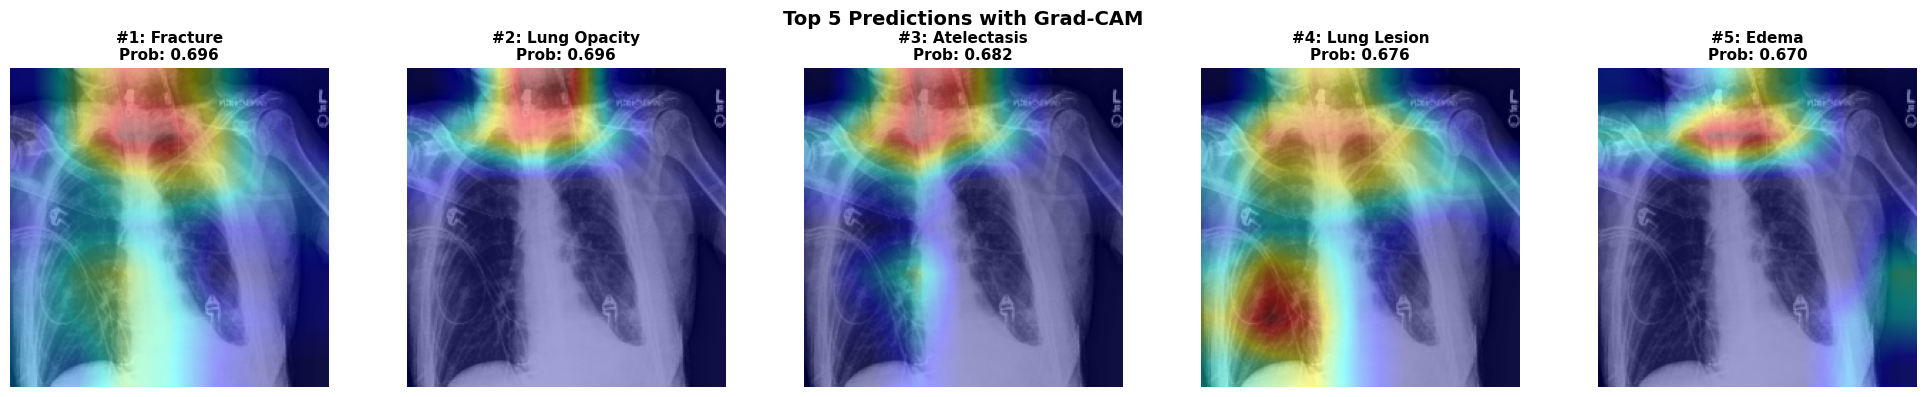

In [64]:
# 8. Top 5 predictions visualization
print("\n" + "="*50)
print("TOP 5 PREDICTIONS")
print("="*50)

top_indices = np.argsort(predictions)[-5:][::-1]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, class_idx in enumerate(top_indices):
    ax = axes[idx]
    pathology = model.pathologies[class_idx]
    prob = predictions[class_idx]
    heatmap = heatmaps[class_idx]
    
    # Overlay heatmap
    visualization = show_cam_on_image(img_rgb, heatmap, use_rgb=True, image_weight=0.6)
    
    ax.imshow(visualization)
    ax.set_title(f"#{idx+1}: {pathology}\nProb: {prob:.3f}", fontsize=11, fontweight='bold')
    ax.axis('off')
    
    print(f"{idx+1}. {pathology:20s}: {prob:.3f}")

plt.suptitle("Top 5 Predictions with Grad-CAM", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('chexpert_top5.png', dpi=150, bbox_inches='tight')
print("\n✓ Top 5 predictions saved as 'chexpert_top5.png'")
plt.show()

In [65]:
# 9. Σύγκριση με Ground Truth (αν υπάρχουν labels)
print("\n" + "="*50)
print("GROUND TRUTH vs PREDICTIONS")
print("="*50)

# Τα labels στο CheXpert: 1.0 = positive, 0.0 = negative, -1.0 = uncertain, NaN = not mentioned
for pathology in model.pathologies:
    if pathology in sample_row:
        gt_value = sample_row[pathology]
        pred_prob = predictions[list(model.pathologies).index(pathology)]
        
        if pd.notna(gt_value):
            gt_str = {1.0: "Positive", 0.0: "Negative", -1.0: "Uncertain"}.get(gt_value, "Unknown")
            match = "✓" if (gt_value == 1.0 and pred_prob > 0.5) or (gt_value == 0.0 and pred_prob <= 0.5) else "✗"
            print(f"{pathology:20s}: GT={gt_str:10s} | Pred={pred_prob:.3f} {match}")

print("\n✅ Analysis complete!")



GROUND TRUTH vs PREDICTIONS
Atelectasis         : GT=Uncertain  | Pred=0.682 ✗
Consolidation       : GT=Uncertain  | Pred=0.645 ✗
Edema               : GT=Positive   | Pred=0.670 ✓
Fracture            : GT=Positive   | Pred=0.696 ✓

✅ Analysis complete!
